In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
from utilis.preprocess import load_data, to_density
from utilis.cluster import Clustering
from utilis.evaluation import Evaluate
from utilis.visualization import plot_Xtrain, plot_clustering, plot_boundary

In [4]:
class Model_runner(object):
    def __init__(self):
       
        self.config = {}
        self.config['data_name'] = '3_14_110c'
        self.config['load_data'] = {
            'file_t1':'data/T1_point.txt',
             'file_t2':'data/T2_point.txt',
             'file_fvol':'data/T1T2_3_14_T110c.txt' # T110c/ as_received
        }
        self.config['preprocess'] = {
            'min_t1t2_ratio':0.5, 
            't1_max': 600, 
            'fc':0.1, 
            'variation_length': 0.01,
            'save':False,
            'filename':'data_process/X_train_{}.txt'
        }
        self.config['clustering']={
            'model_names' : ['GMM','kmean'],
            'n_clusters': 5,
            'adjust_label': True,
            'save_model':False,
            'file_dir':'model/'
        } 
        
        self.config['evaluate']={
        'distance_min':0.05,
        'point_min': 50 #0.05, point_min = 50   
        }
        
        self.data_name = self.config['data_name']
        self.config['clustering']['file_dir'] += self.data_name
        self.t1_domain = None
        self.t2_domain = None
        self.t2_grid = None
        self.t1_grid = None
        self.f_grid = None
        self.X_train = None 
        self.X_manifold = None
        
        
    def load_data(self,verbose=0):
        self.t1_grid, self.t2_grid, self.f_grid = load_data(self.config['load_data'],verbose=verbose)
        return self
    
    def preprocess(self, verbose=0):
        self.X_train, self.X_manifold = to_density(self.t2_grid, self.t1_grid, self.f_grid, 
            self.config['preprocess'], verbose)
        return self
    
    def fit(self, verbose=0):
        clustering = Clustering(self.X_train, self.config['clustering'], verbose=verbose)
        clustering.model_init()
        clustering.fit()
        self.model_names = clustering.model_names
        self.y_preds = clustering.y_preds
        return self
    
    def evaluate(self, verbose=0):
        evalu = Evaluate(self.model_names, self.X_train, self.y_preds, self.config['evaluate'], verbose=verbose)
        evalu.fit()
        self.metrics = evalu.metrics
        self.boundary_points = evalu.boundary_points
#             self.y_preds[model] = clustering(self.models[model], self.X_train, adjust_label = adjust_label, verbose=verbose)

In [8]:
nmr_cluster = Model_runner()
nmr_cluster.load_data(verbose=1).preprocess(verbose=1).fit(verbose=0)
#nmr_cluster.preprocess(verbose=1)
nmr_cluster.evaluate(verbose=1)

file info, Grid shape of [t1,t2]: (151, 121), log(t1) incremental: -0.03333, log(t2) incremental: -0.04167
Normalization : raw fluid volume 1.44242 , select fluid volume 1.17377, their ratio 0.814
X_trian shape:(10173, 2), X_manifold shape: (2689, 3)
adjust labels (remapping)
adjust labels (remapping)
model_name GMM, metrics ratios [2.8859820385489803, 5.3467204072826409, 30.415915977588977, 10.557681012010557, 57.122598567345683], slopes [14.142268524316755, 8.3668410546685408, 4.5357548692245686], inters[0.14024505156228417, 0.7207471784388344, 1.9412442406479657]
model_name kmean, metrics ratios [16.061951785231752, 39.702692573544496, 42.26778467348813, 49.780709325487571, 57.122598567345683], slopes [52.068413654044882, 44.126965832267778, 44.228031335407834], inters[-0.84026649292168276, -0.019516907094169762, 0.71965916883596914]


In [9]:
slopes = nmr_cluster.metrics['slopes']['GMM']
slopes_raw = nmr_cluster.metrics['slopes_raw']['GMM']
inters = nmr_cluster.metrics['inters']['GMM']
print(slopes_raw)

[59.142268524316755, 53.366841054668541, 49.535754869224569]


[-1  1] [-0.89198226  1.17247236]
[-1  1] [-0.21067991  1.65217427]
[-1  1] [ 1.07668222  2.80580626]


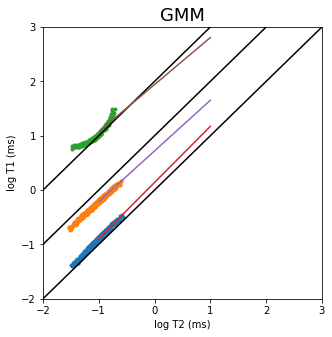

In [14]:
plot_boundary(nmr_cluster.boundary_points['GMM'], 'GMM')
for i in range(3):
    x = np.array([-1, 1])
    y = x*slopes_raw[i]*np.pi/180 + inters[i]
    print(x,y)
    plt.plot(x,y)
#plt.plot([-2,3],[1.05,1.05])
#plt.plot([-2,3],[0.5,0.5])

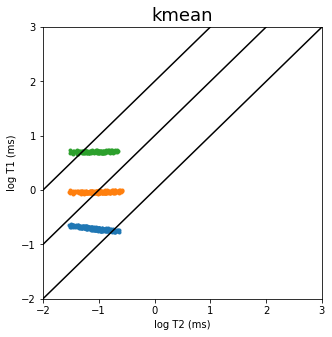

In [15]:
plot_boundary(nmr_cluster.boundary_points['kmean'], 'kmean')

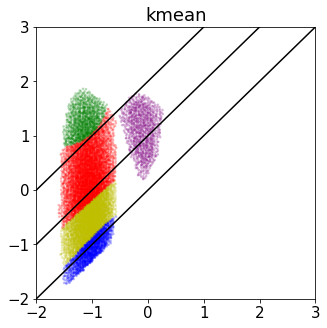

In [13]:
plot_clustering(nmr_cluster.X_train, nmr_cluster.y_preds['GMM'],model_name='kmean', plot_line=True,plot_save=False)